In [1]:
# Standard Python imports
import os
import copy
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Astropy imports
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, LogStretch
import astropy.io.fits as pyfits

# Lenstronomy imports
import lenstronomy
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Data.psf import PSF
from lenstronomy.Util import kernel_util
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import mask_util, util



/home/rmbrady/miniconda3/envs/HST/lib/python3.12/site-packages/lenstronomy/Data/psf.py:95: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(
/tmp/ipykernel_1142066/1595508132.py:15: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kernel_psf_class))


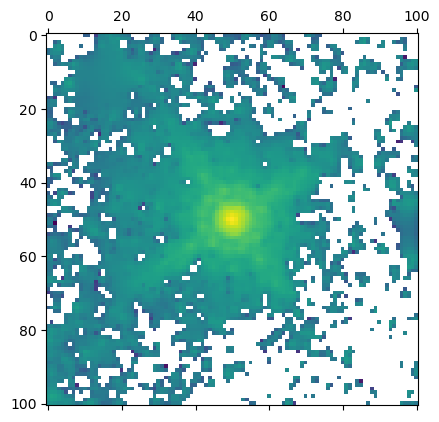

In [2]:
# load PSF data
psf_file = 'outputs/full_PSF.fits'

kernel = pyfits.getdata(psf_file)
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 301

kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'kernel_point_source': kernel_cut, 
              'point_source_supersampling_factor': 3}
psf_class = PSF(**kwargs_psf)

kernel_psf_class = psf_class.kernel_point_source

plt.matshow(np.log10(kernel_psf_class))
plt.show()

In [3]:
# Open the FITS file and extract the header
filename = 'J2325-5229_F160W_cutout.fits'

with fits.open(filename) as hdul:
    header = hdul[0].header
    image_data = hdul[0].data 

# read out matrix elements and convert them in units of arc seconds
CD1_1 = header['CD1_1'] * 3600  # change in arc sec per pixel d(ra)/dx
CD1_2 = header['CD1_2'] * 3600
CD2_1 = header['CD2_1'] * 3600
CD2_2 = header['CD2_2'] * 3600

# generate pixel-to-coordinate transform matrix and its inverse
pix2coord_transform_undistorted = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
det = CD1_1*CD2_2 - CD1_2*CD2_1
coord2pix_transform_undistorted = np.array([[CD2_2, -CD1_2], [-CD2_1, CD1_1]])/det

# as an example, we set the coordinate zero point in the center of the image and compute 
# the coordinate at the pixel (0,0) at the edge of the image

# read out pixel size of image
nx = header.get('NAXIS1')
ny = header.get('NAXIS2')
x_c = int(nx / 2)
y_c = int(ny / 2)

# compute RA/DEC relative shift between the edge and the center of the image
dra, ddec = pix2coord_transform_undistorted.dot(np.array([x_c, y_c]))
# set edge of the image such that the center has RA/DEC = (0,0)
ra_at_xy_0, dec_at_xy_0 = -dra, -ddec

# import the PixelGrid() class #

deltaPix = 0.13  # size of WFC3 pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': nx, 'ny': ny,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates




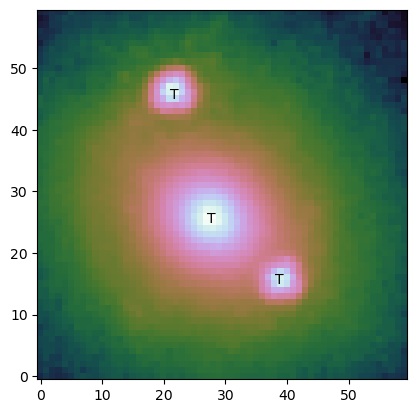

In [4]:
# display science image and obtain coordinates of point source and lens centers
x1, y1 = 21, 45
x2, y2 = 27, 25
x3, y3 = 38, 15

plt.annotate('T', [x1,y1], color='black')
plt.annotate('T', [x2,y2], color='black')
plt.annotate('T', [x3,y3], color='black')

plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')

im1 = pixel_grid.map_pix2coord(x1, y1)

lens_pos = pixel_grid.map_pix2coord(x2,y2)

im2 = pixel_grid.map_pix2coord(x3,y3)

In [5]:
# set up data class
kwargs_data = {'image_data': image_data,
               'background_rms': header['BACK_RMS'],
               'exposure_time': header['EXPTIME'],
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle} 

# lens coordinates
lens_center_x, lens_center_y = lens_pos[0], lens_pos[1]
# image coordinates #
im1_x, im1_y = im1[0], im1[1]
im2_x, im2_y = im2[0], im2[1]

# calculate the initial guess for theta_E as half the image separation
einstein_rad = np.sqrt((im2_x - im1_x)**2 + (im2_y - im1_y)**2) / 2
print(f'Initial guess for theta_E: {einstein_rad}')

# set up point source and lens positions
theta_ra = np.array([im1_x, im2_x])
theta_dec = np.array([im1_y, im2_y])

Initial guess for theta_E: 2.241322154443667


/tmp/ipykernel_1142066/3023437358.py:39: RuntimeWarning: divide by zero encountered in log10
  image = np.log10(kwargs_data["image_data"] * mask_img)


Text(0.5, 1.0, 'IMAGE AFTER MASKING')

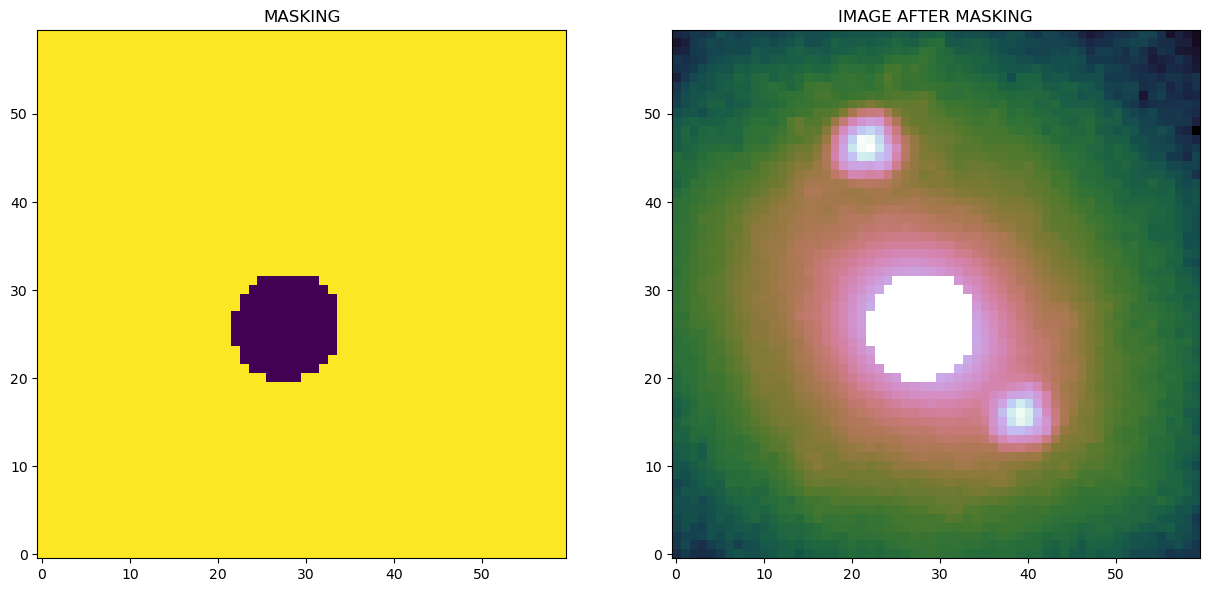

In [6]:
# create a central mask

num_pix = len(kwargs_data["image_data"])

r1 = 7 # arcsecond
lens_center_ra = lens_center_x
lens_center_dec = lens_center_y

mask_outer_1 = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec + .35,
    r1,
    util.image2array(x_coords),
    util.image2array(y_coords),
)

mask_ext_6 = mask_util.mask_ellipse(    # Central Mask
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + .1,
    lens_center_dec + .1,
    0.8,
    0.8,
    0,
)

mask_1 = (1 - mask_outer_1)
mask_3 = (1 - mask_ext_6) 
mask1 = mask_1 * mask_3
mask1[mask1 >= 1] = 1

mask1[mask1 < 0] = 0


mask_img = mask1.reshape(num_pix, num_pix)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))


image = np.log10(kwargs_data["image_data"] * mask_img)


plt.sca(axs[0])
plt.imshow(mask_img, origin="lower")
plt.title("MASKING")


plt.sca(axs[1])
plt.imshow(image, origin="lower", cmap="cubehelix")
plt.title("IMAGE AFTER MASKING")

In [7]:
# model parameters
lens_model_list = ['EPL', 'SHEAR']

lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']

source_model_list = ['SERSIC_ELLIPSE']

point_source_list = ['LENSED_POSITION']

In [8]:
# set up model arguments

kwargs_model = {'lens_model_list': lens_model_list,
                               'lens_light_model_list': lens_light_model_list,
                               'point_source_model_list': point_source_list,
                               'source_light_model_list': source_model_list}

kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False,
                   'point_source_supersampling_factor': 3}


kwargs_constraints = {'num_point_source_list': [2],
                              'joint_lens_with_light': [[0, 0, ['center_x', 'center_y']]],
                              'joint_source_with_point_source': [[0, 0]],
                              'joint_lens_light_with_lens_light': [[0, 1, ['center_x', 'center_y']]]
                              }

kwargs_likelihood = {'check_bounds': True,
                     'image_likelihood_mask_list': [mask_img],
                      #'image_position_uncertainty': 0.004,
                        #'check_matched_source_position': True,
                              #'source_position_tolerance': 0.001
                              }


image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

/home/rmbrady/miniconda3/envs/HST/lib/python3.12/site-packages/lenstronomy/LensModel/Profiles/epl.py:297: RuntimeWarning: invalid value encountered in divide
  R_omega = Z * hyp2f1(1, t / 2, 2 - t / 2, -(1 - q) / (1 + q) * (Z / Z.conj()))


Computing the PSO ...


100%|██████████| 500/500 [04:34<00:00,  1.82it/s]
/home/rmbrady/miniconda3/envs/HST/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:67: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/home/rmbrady/miniconda3/envs/HST/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:224: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),


Max iteration reached! Stopping.
-9.134096940737631 reduced X^2 of best position
-15770.01836818352 log likelihood
3453 effective number of data points
[{'theta_E': 2.53145315450116, 'gamma': 2, 'e1': 0.1845065859529813, 'e2': -0.08364044748013953, 'center_x': 5.98209959040566, 'center_y': 0.9341354700298451}, {'gamma1': 0.09601395698065596, 'gamma2': 0.010377526776898108, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.29976578617171296, 'n_sersic': 1.0, 'e1': 0.18242358617960241, 'e2': -0.062193121395513445, 'center_x': 5.133198698342872, 'center_y': 1.3437265022025486}] source result
[{'amp': 1, 'R_sersic': 2.7803430850996236, 'n_sersic': 3.017791222819457, 'e1': -0.03193749390060505, 'e2': -0.1394581155679997, 'center_x': 5.98209959040566, 'center_y': 0.9341354700298451}, {'amp': 1, 'R_sersic': 2.9716836083680653, 'n_sersic': 3.491502468457358, 'e1': -0.020595455194708824, 'e2': -0.13185968919168814, 'center_x': 5.98209959040566, 'center_y': 0.9341354700298451}] lens 

/home/rmbrady/miniconda3/envs/HST/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:1218: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


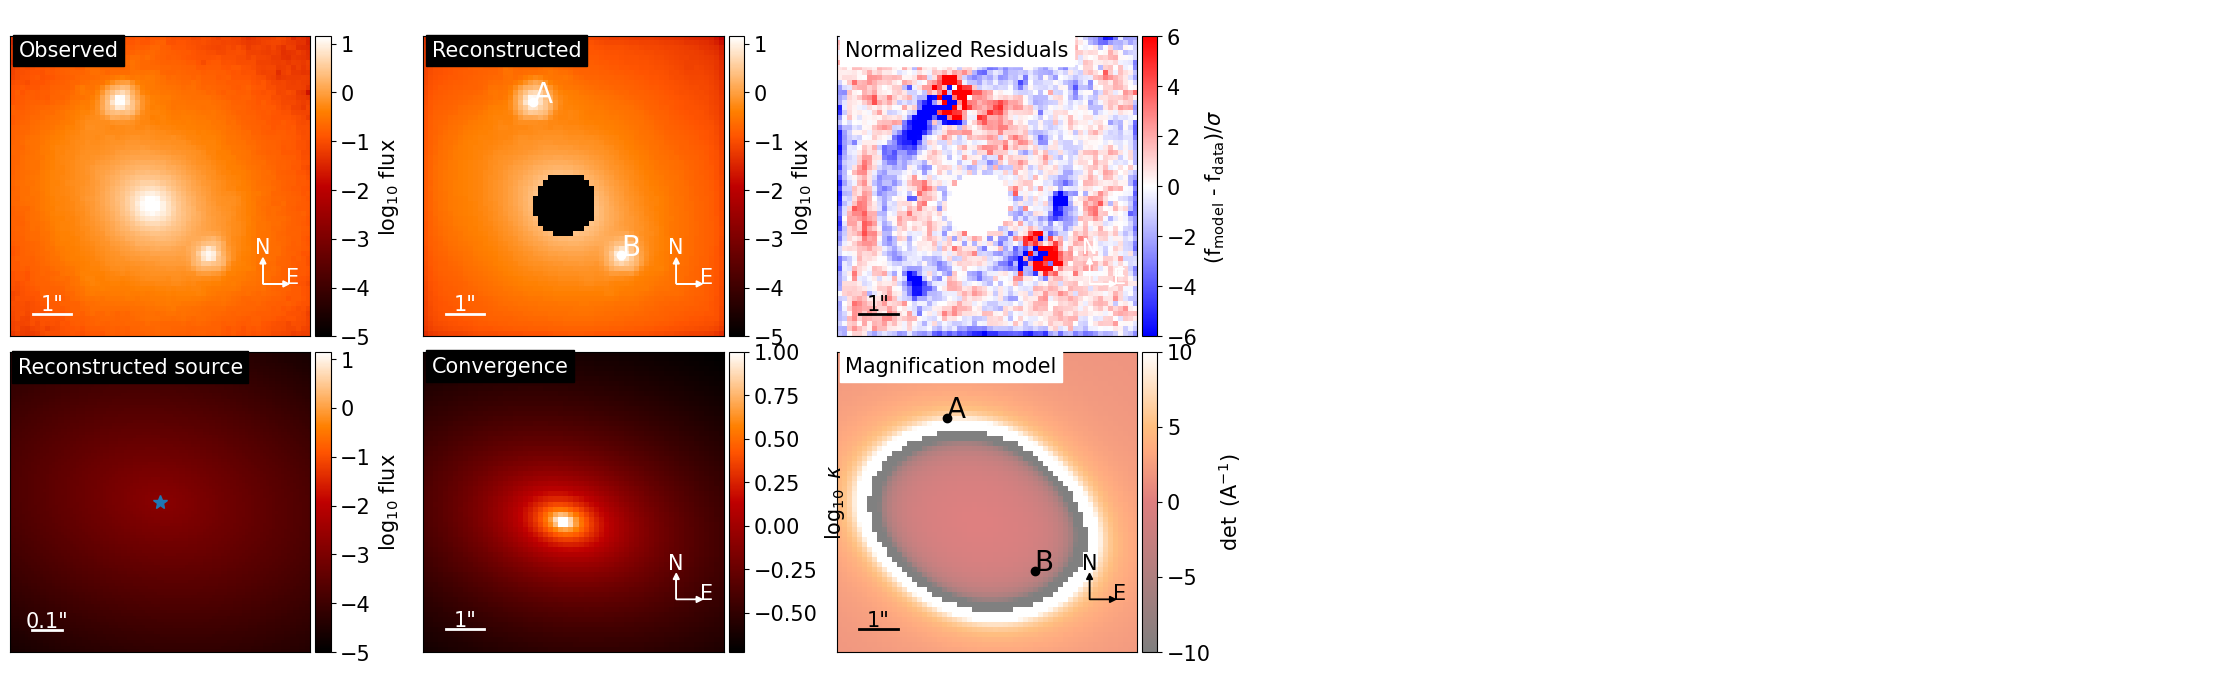

In [9]:
# initial guess of non-linear parameters
kwargs_lens_init = [{'theta_E': einstein_rad, 'gamma': 2., 'e1': .0, 'e2': .0, 'center_x': lens_center_x, 'center_y': lens_center_y},
                    {'gamma1': 0., 'gamma2': 0., 'ra_0': 0, 'dec_0': 0}]
kwargs_lens_light_init = [{'R_sersic': 2., 'n_sersic': 3., 'e1': .1, 'e2': .0, 'center_x': lens_center_x, 'center_y': lens_center_y},
                          #{'amp': 20}]
                          {'R_sersic': 3., 'n_sersic': 4., 'e1': 0.1, 'e2': .0, 'center_x': lens_center_x, 'center_y': lens_center_y}]
kwargs_source_init = [{'R_sersic': 0.1, 'n_sersic': 1., 'e1': -.1, 'e2': -.1, 'center_x': lens_center_x, 'center_y': lens_center_y}]
kwargs_ps_init = [{'ra_image': theta_ra, 'dec_image': theta_dec}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.2, 'gamma': .5, 'e1': .5, 'e2': .5, 'center_x': 0.1, 'center_y': 0.1},
                     {'gamma1': -0.3, 'gamma2': -0.3, 'ra_0': 10, 'dec_0': 10}]
kwargs_lens_light_sigma = [{'R_sersic': .1, 'n_sersic': .1, 'e1': .5, 'e2': .5, 'center_x': .1, 'center_y': 0.1},
                           #{'amp': 10}]
                           {'R_sersic': .5, 'n_sersic': .5, 'e1': .5, 'e2': .5, 'center_x': .1, 'center_y': 0.1}]
kwargs_source_sigma = [{'R_sersic': .5, 'n_sersic': .5, 'e1': 0.5, 'e2': 0.5, 'center_x': .5, 'center_y': .5}]
kwargs_ps_sigma = [{'ra_image': [0.02] * 2, 'dec_image': [0.02] * 2}]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0.01, 'gamma': 1., 'e1': -0.25, 'e2': -0.25, 'center_x': -10., 'center_y': -10},
                     {'gamma1': -0.3, 'gamma2': -0.3, 'ra_0': -100, 'dec_0': -100}]
kwargs_lower_lens_light = [{'R_sersic': 0.5, 'n_sersic': 0.5, 'e1': -0.25, 'e2': - 0.25, 'center_x': -10, 'center_y': -10},
                           #{'amp': -100}]
                           {'R_sersic': 0.5, 'n_sersic': 0.5, 'e1': -0.25, 'e2': - 0.25, 'center_x': -10, 'center_y': -10}]
kwargs_lower_source = [{'R_sersic': 0.01, 'n_sersic': 1., 'e1': -0.25, 'e2': -0.25, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(theta_ra), 'dec_image': -10 * np.ones_like(theta_dec)}]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 10, 'gamma': 3., 'e1': 0.25, 'e2': 0.25, 'center_x': lens_center_x + 1, 'center_y': 10},
                     {'gamma1': 0.3, 'gamma2': 0.3, 'ra_0': 100, 'dec_0': 100}]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.25, 'e2': 0.25, 'center_x': lens_center_x + 1, 'center_y': 10},
                           #{'amp': 100}]
                           {'R_sersic': 10, 'n_sersic': 5., 'e1': 0.25, 'e2': 0.25, 'center_x': lens_center_x + 1, 'center_y': 10}]
kwargs_upper_source = [{'R_sersic': .3, 'n_sersic': 1., 'e1': 0.25, 'e2': 0.25, 'center_x': lens_center_x + 1, 'center_y': 10}]
kwargs_upper_ps = [{'ra_image': 12 * np.ones_like(theta_ra), 'dec_image': 10 * np.ones_like(theta_dec)}]


lens_params = [kwargs_lens_init, kwargs_lens_sigma, [{'gamma': 2}, {'ra_0': 0, 'dec_0': 0}], kwargs_lower_lens, kwargs_upper_lens]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, [{}, {}], kwargs_lower_lens_light, kwargs_upper_lens_light]
source_params = [kwargs_source_init, kwargs_source_sigma, [{}], kwargs_lower_source, kwargs_upper_source]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, [{}], kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params}

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)


fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 500}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
multi_band_list = fitting_seq.multi_band_list

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"], arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()

iteration of step 3 gave best reconstruction.
log likelihood before: -15768.771639391605 and log likelihood after: -9733.467259702975
-5.5923397068100975 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  5.5923397068064435


/home/rmbrady/miniconda3/envs/HST/lib/python3.12/site-packages/lenstronomy/Plots/chain_plot.py:138: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(psf_in), origin="lower", **kwargs)
/home/rmbrady/miniconda3/envs/HST/lib/python3.12/site-packages/lenstronomy/Plots/chain_plot.py:159: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(psf_out), origin="lower", **kwargs)
/home/rmbrady/miniconda3/envs/HST/lib/python3.12/site-packages/lenstronomy/Plots/chain_plot.py:200: RuntimeWarning: divide by zero encountered in log10
  np.log10(psf_variance_map * psf.kernel_point_source**2),
/home/rmbrady/miniconda3/envs/HST/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:1111: RuntimeWarning: invalid value encountered in log10
  np.log10(model),
/home/rmbrady/miniconda3/envs/HST/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:1168: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data - model

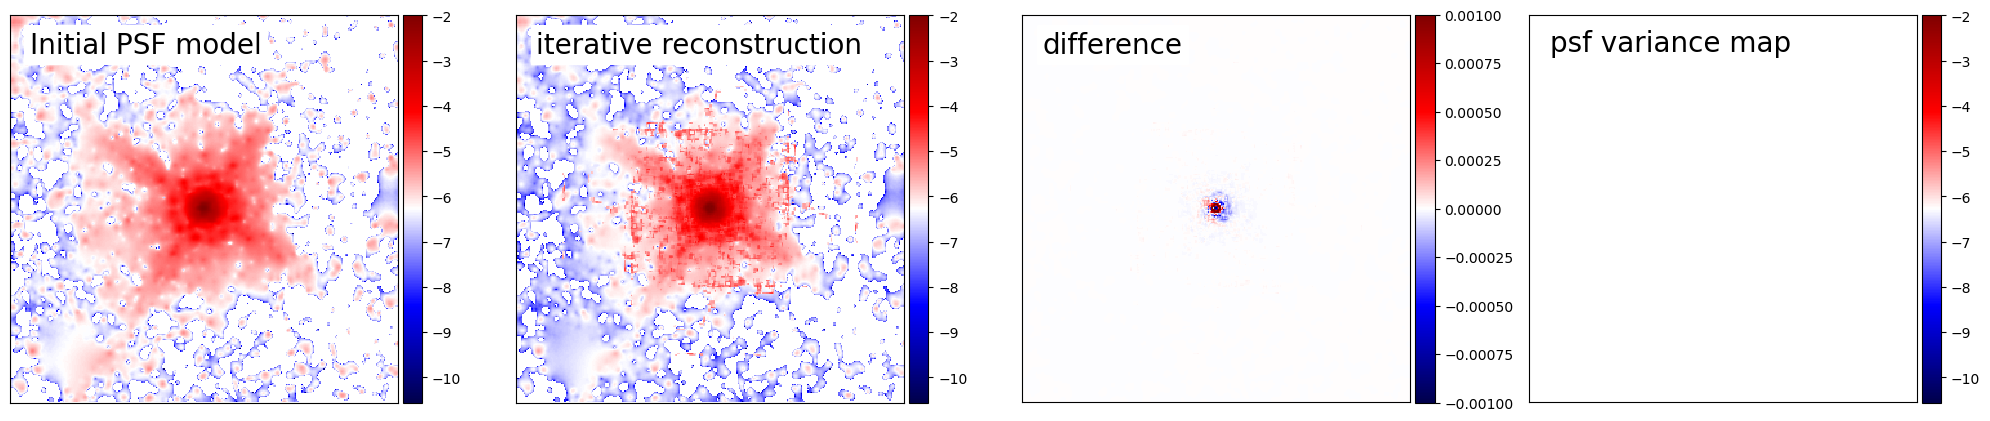

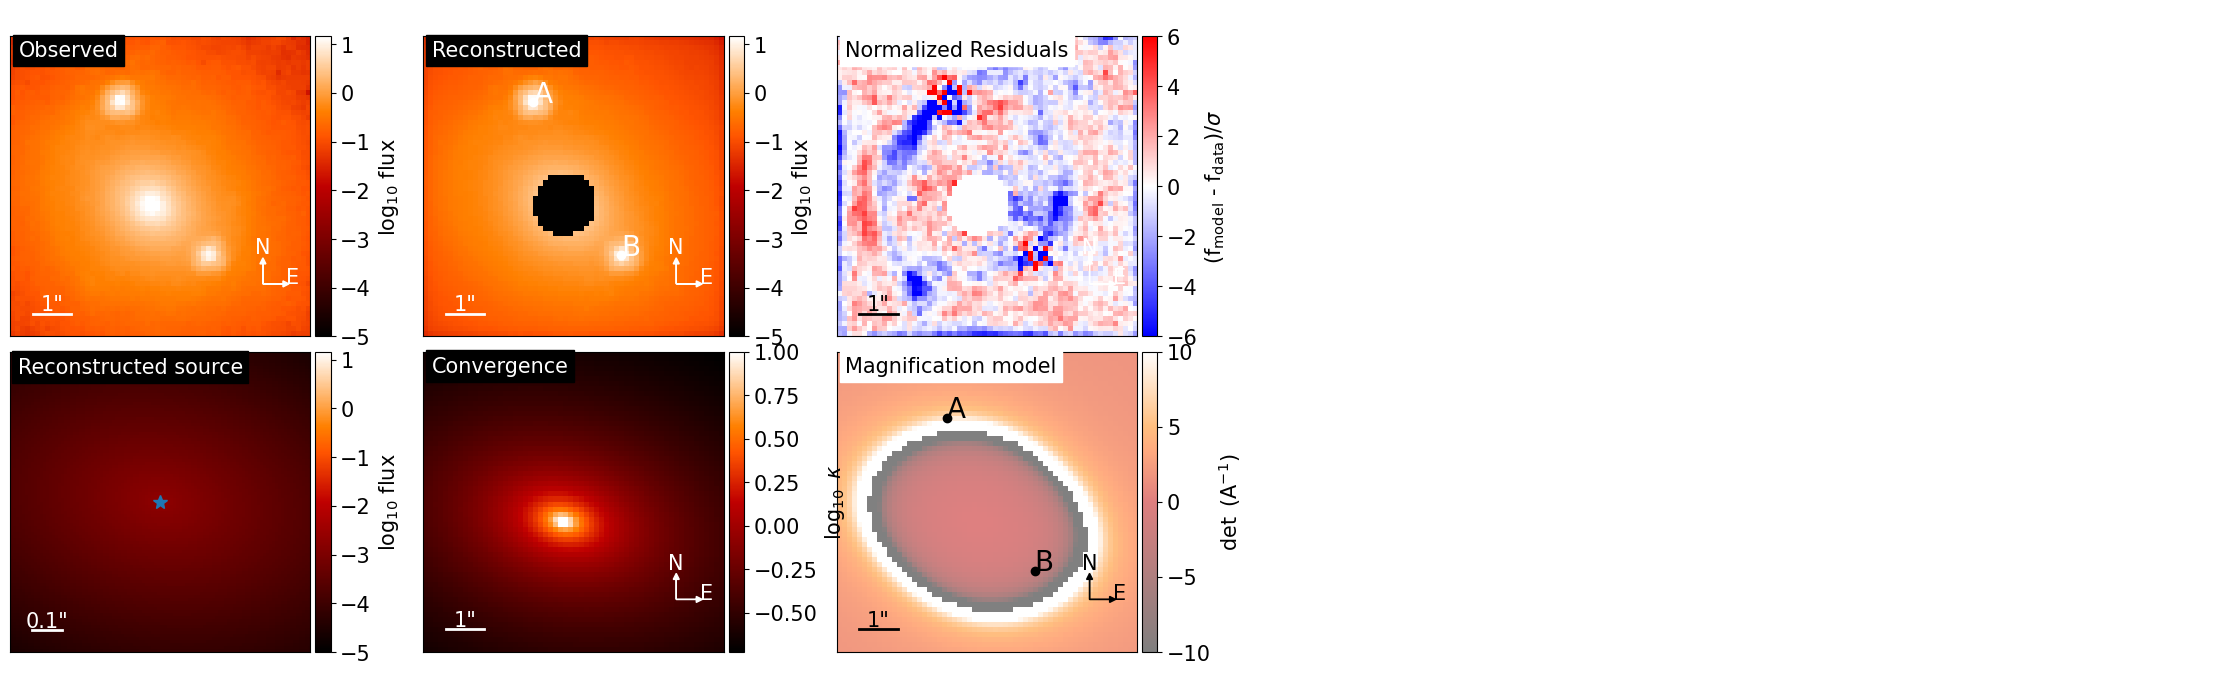

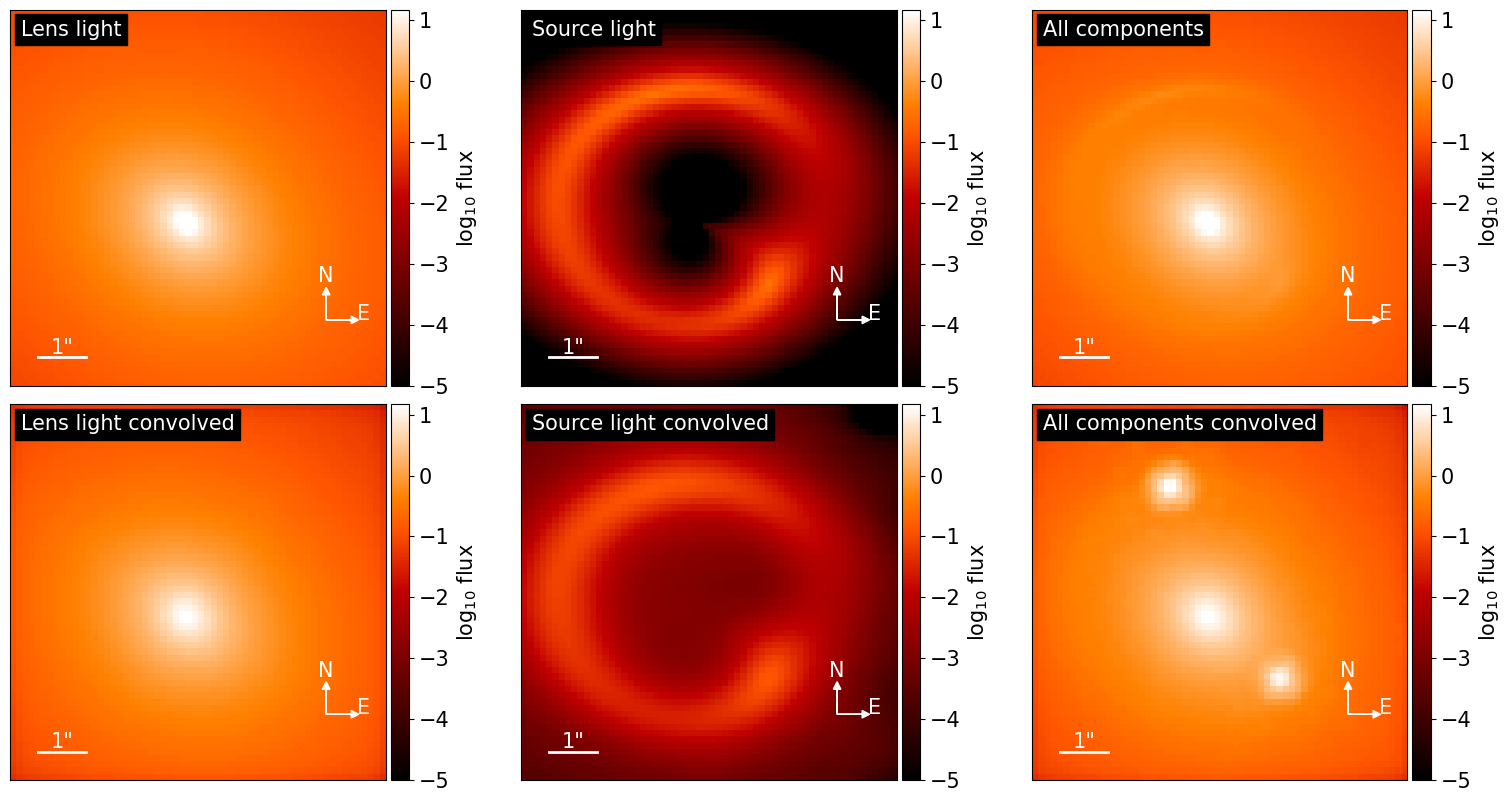

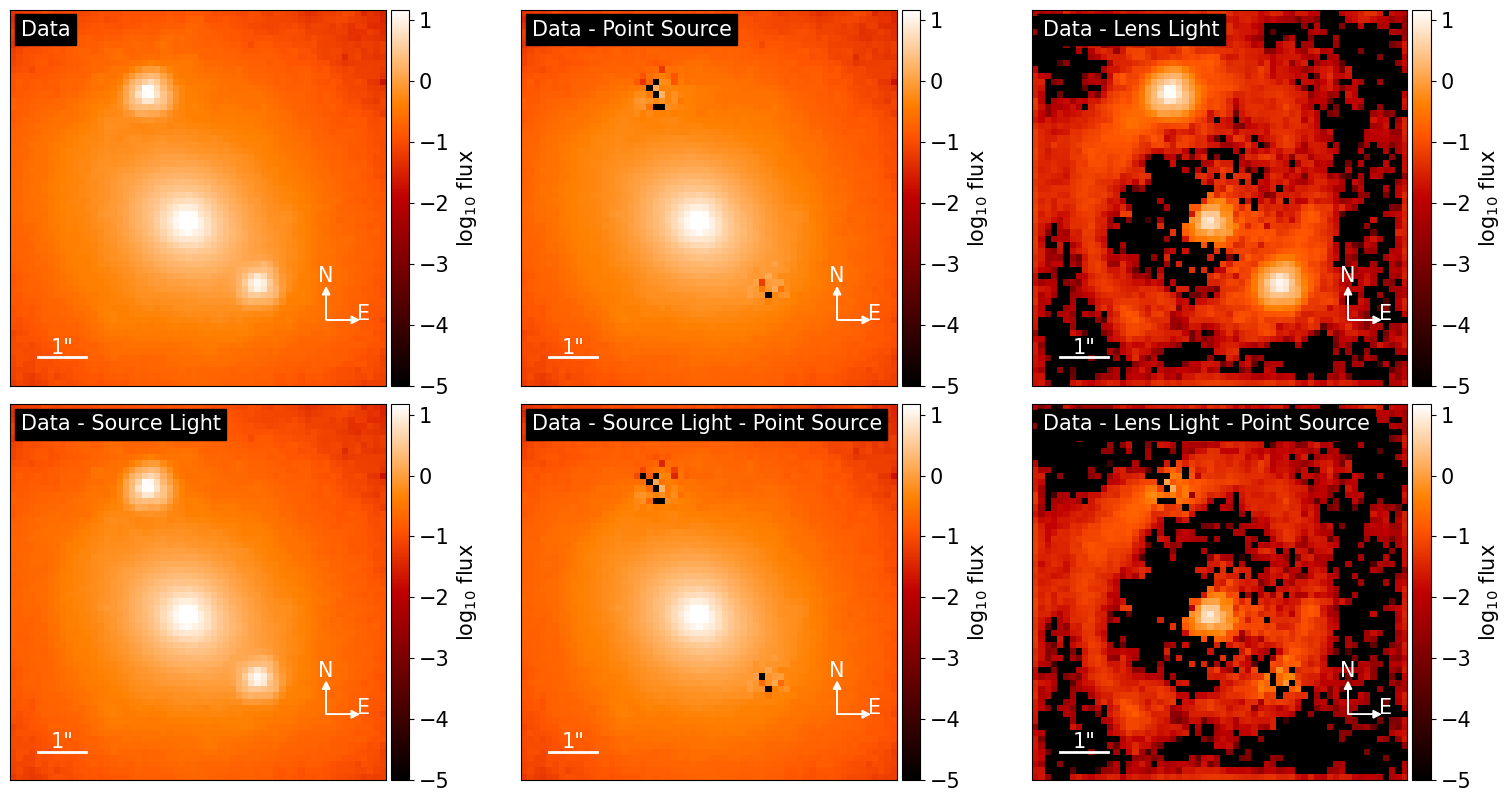

In [10]:
#now we run an iterative PSF reconstruction with the best fit model of the previous run
method_PSF_iteration = 'stack' #use 'STARRED' to use the STARRED method for PSF reconstruction or 'stack' to use the standard lenstronomy stacking method

kwargs_lbfgs = {'maxiter':1000}

kwargs_optax1 = {'max_iterations': 500, 'min_iterations': None,
                'init_learning_rate': 1e-2, 'schedule_learning_rate': True,
                'progress_bar': True} 

if method_PSF_iteration == 'STARRED':
    kwargs_psf_iter = { 
                    'keep_psf_error_map': True, 
                    'psf_symmetry': 1, 
                    'block_center_neighbour': 0.05,
                    'num_iter': 3, #we run STARRED more than once, to see if the chi2 keeps improving after redoing the linear inversion with the new PSF. 
                    'psf_iter_factor': 1, #We fully update the PSF at each iteration, if the fit improves
                    'kwargs_starred': {'verbose':True, 'lambda_scales':3, 'lambda_hf':3, #Choose regularisation parameters, lambda_scales and lambda_hf should be 2 or 3 if the noise is correctly scaled 
                                       'optim_list':['adabelief', 'adabelief'], 'kwargs_optim_list':[kwargs_optax1, kwargs_optax1],#Choose the optimisers to use, and pass the kwargs accordingly. One for the Moffat fit, one for the full PSF fit. 
                                       }, 
                    'use_starred': True, 
                    } 

else: 
    kwargs_psf_iter = {'stacking_method': 'median', 
                    'psf_symmetry': 4, 
                    'block_center_neighbour': 0.05,
                    'num_iter': 100, 
                    'psf_iter_factor': 0.2}

fitting_kwargs_list = [['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)

multi_band_list = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]
f, axes = chain_plot.psf_iteration_compare(kwargs_psf_updated)
f.show()
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"], arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()
f, axes = modelPlot.plot_separate()
f.show()
f, axes = modelPlot.plot_subtract_from_data_all()
f.show()

Computing the PSO ...


100%|██████████| 1000/1000 [10:43<00:00,  1.55it/s]


Max iteration reached! Stopping.
-4.883014661921519 reduced X^2 of best position
-8430.524813807502 log likelihood
3453 effective number of data points
[{'theta_E': 2.4079586321424222, 'gamma': 2, 'e1': 0.05721655454853329, 'e2': -0.037852142372610115, 'center_x': 5.996436968738378, 'center_y': 0.9368665764326881}, {'gamma1': -0.004626248572422787, 'gamma2': 0.009014841490878658, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.29290110873513747, 'n_sersic': 1.0, 'e1': -0.07324775103400359, 'e2': 0.07718792820011539, 'center_x': 5.786120643211397, 'center_y': 1.2008043479116521}] source result
[{'amp': 1, 'R_sersic': 2.7820978694063463, 'n_sersic': 3.0513491531664423, 'e1': -0.04890554797909033, 'e2': -0.14066662118814624, 'center_x': 5.996436968738378, 'center_y': 0.9368665764326881}, {'amp': 1, 'R_sersic': 2.983802179661763, 'n_sersic': 3.5447252027009877, 'e1': -0.03458092879736185, 'e2': -0.13323751170657924, 'center_x': 5.996436968738378, 'center_y': 0.936866576432688

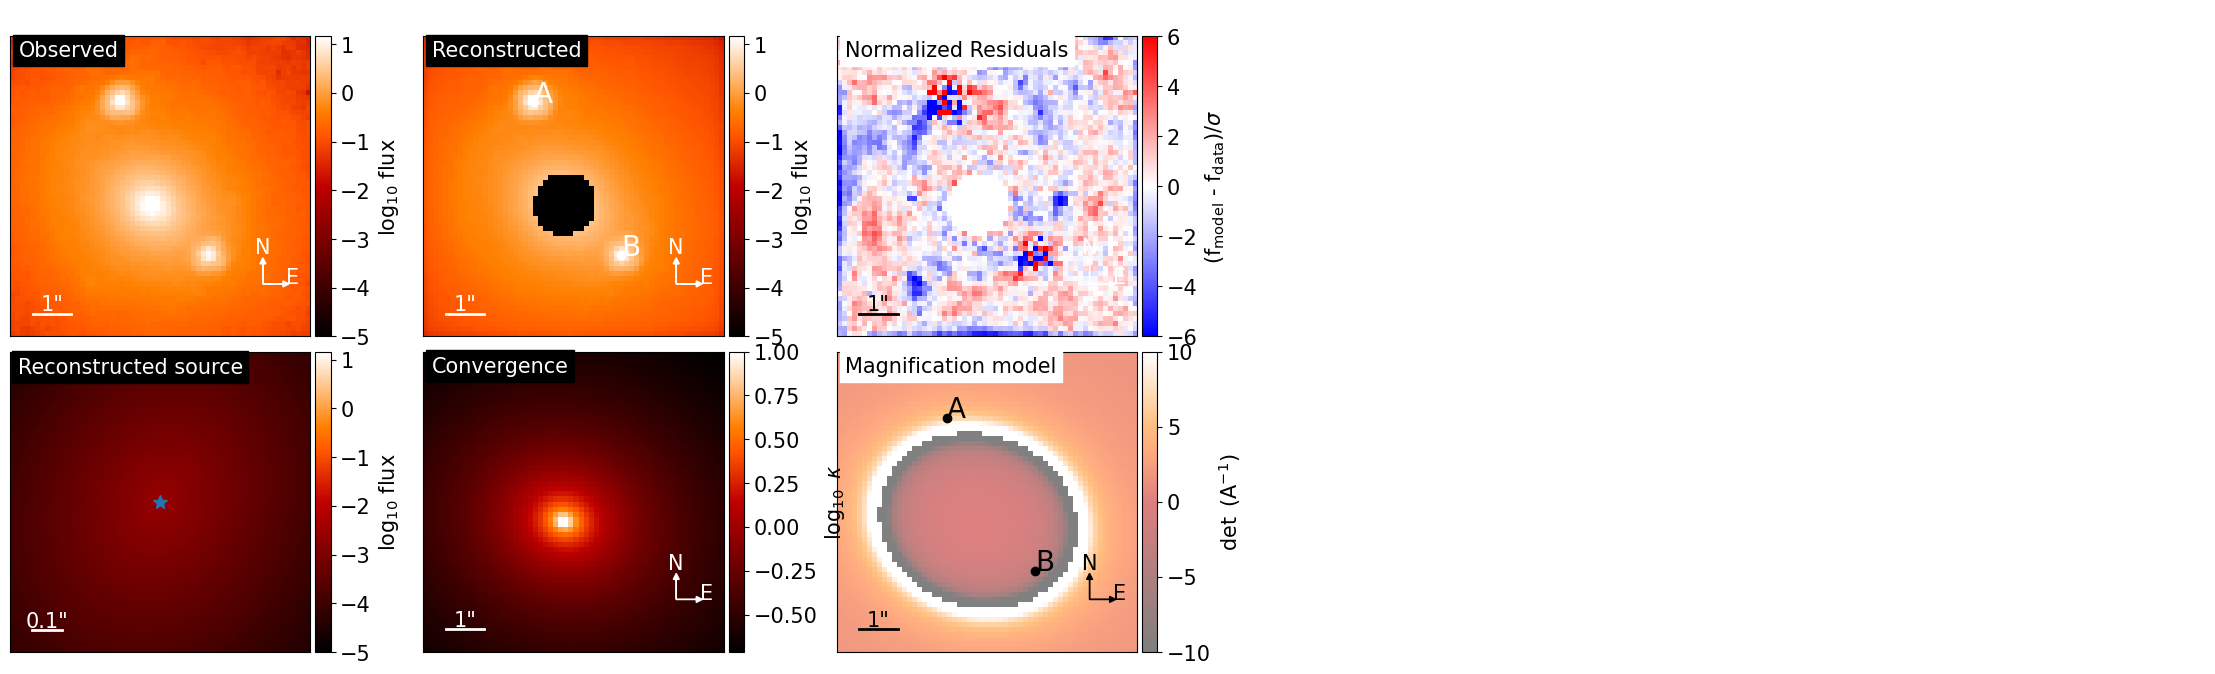

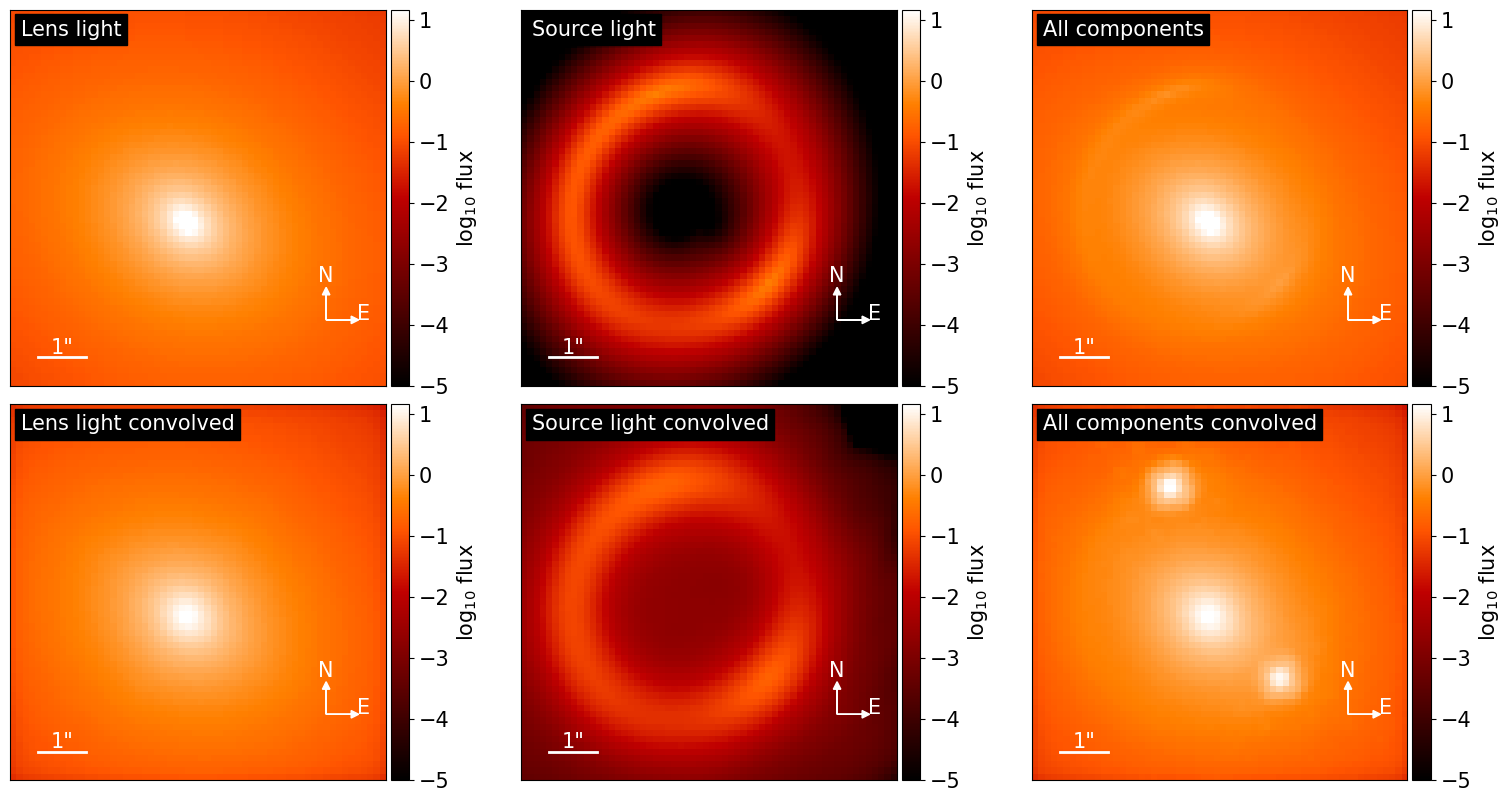

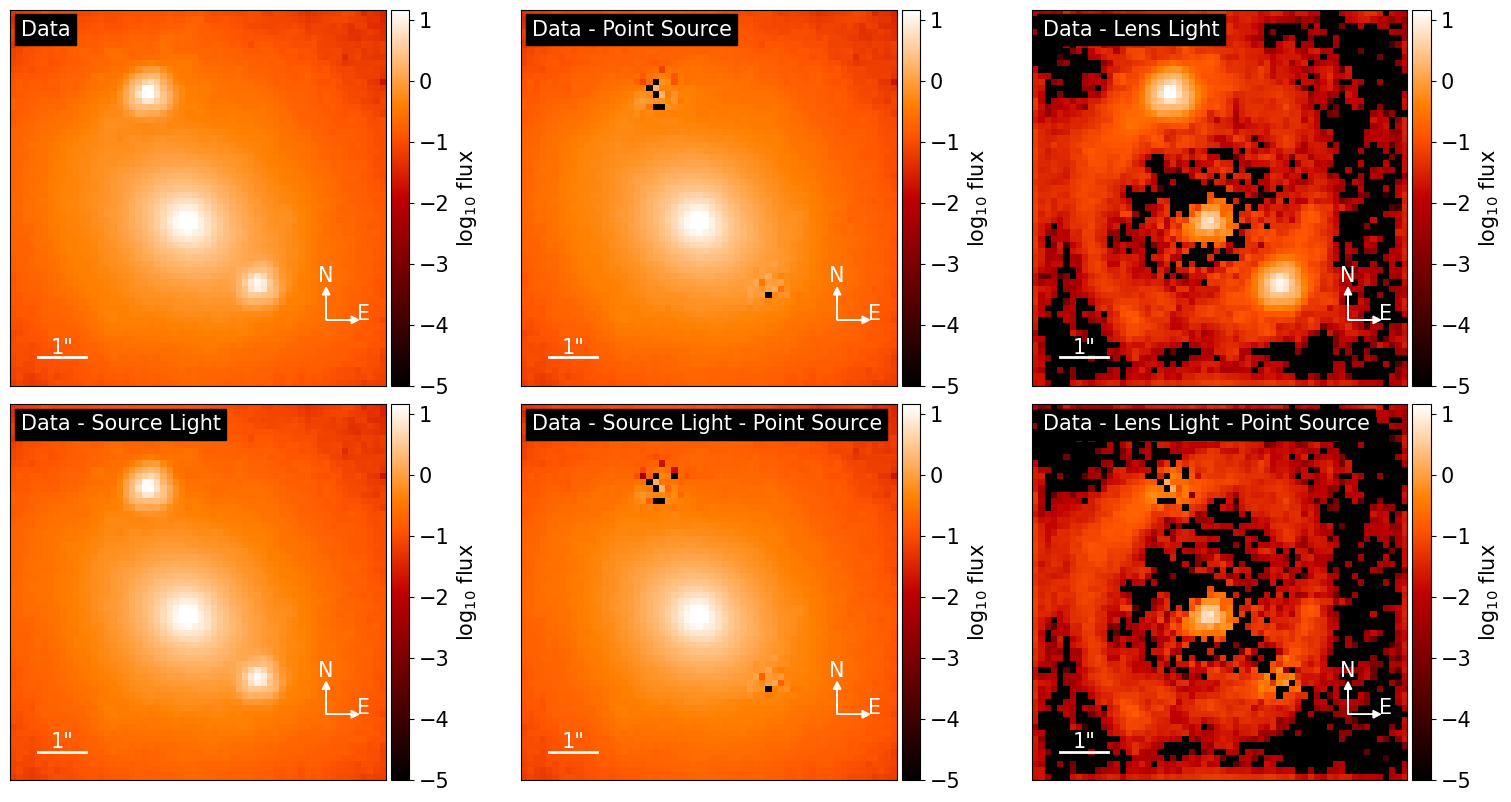

In [11]:
# run the fitting again with more iterations
fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 1000}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
multi_band_list = fitting_seq.multi_band_list

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"], arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()
f, axes = modelPlot.plot_separate()
f.show()
f, axes = modelPlot.plot_subtract_from_data_all()
f.show()

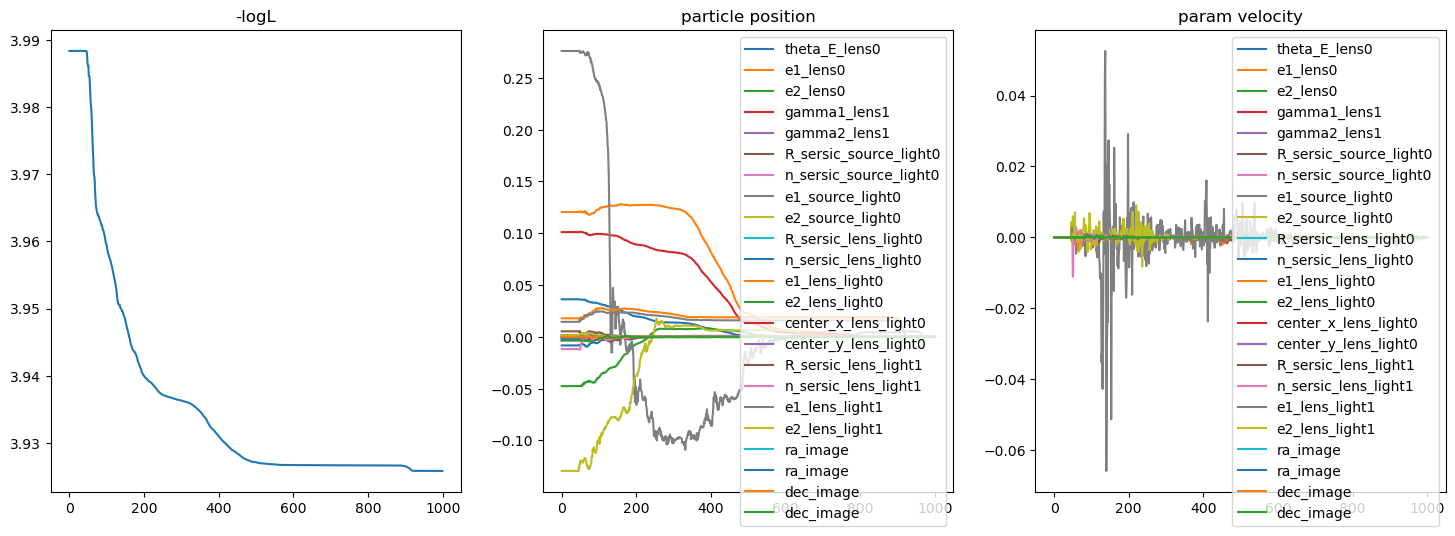

<Figure size 640x480 with 0 Axes>

In [12]:
# analyze the PSO
param = fitting_seq.param_class

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)


In [13]:
# save the data for easy plotting and later analysis
import pickle

save_dict = {
    "kwargs_result": kwargs_result,
    "multi_band_list": multi_band_list,
    "kwargs_model": kwargs_model
}

with open("j2325_f160w_fit.pkl", "wb") as f:
    pickle.dump(save_dict, f)
